![Notebooks in Portuguese](https://img.shields.io/badge/Notebooks-Portuguese-yellow?style=flat-square)
![Translate with jupyter-translate](https://img.shields.io/badge/Translate-Jupyter--Translate-blue?style=flat-square)
> ⚠️ **Note:** The notebooks in this repository are written in Portuguese, but the code, functions, and variables are all in English.  
> If you prefer another language, use tools like [jupyter-translate](https://github.com/WittmannF/jupyter-translate) to automatically translate cells inside JupyterLab.  
> See [USAGE.md](./USAGE.md) for function documentation in both Portuguese and English.


# 🛰️ Extração do MapBiomas + SRTM + Relevo para um ROI

Este notebook demonstra como utilizar a função `extract_mapbiomas` para extrair dados multitemporais de uso e cobertura da terra a partir da **Coleção 9 do MapBiomas** para um determinado ROI (Região de Interesse), utilizando a plataforma Google Earth Engine.

A função permite:

- **Selecionar um intervalo de anos** (1985 a 2022) para gerar uma série temporal espacializada das classes do MapBiomas;
- **Incluir opcionalmente o SRTM** (modelo de elevação) com interpolação espacial para compatibilidade com o grid da série temporal;
- **Adicionar variáveis topográficas derivadas**, como `slope`, `aspect` e `hillshade`, usando `ee.Terrain`;
- **Recortar com precisão** ao ROI definido pelo usuário;
- **Exportar os dados como um `xarray.Dataset` com coordenadas geográficas e metadados completos**, pronto para salvar como NetCDF ou processar com bibliotecas Python;
- **Gerenciar arquivos temporários automaticamente**, garantindo limpeza ao final do processo;
- **Personalizar comentários e escala**, além de acompanhar o progresso com `tqdm`.

O resultado é um dataset estruturado com dimensões `(time, y, x)`, contendo uma variável de classificação de uso da terra por ano, além de camadas opcionais de elevação e relevo, facilitando análises ambientais, espaciais e temporais em projetos científicos e aplicados.


In [1]:
import warnings ## <- apenas para deixar a saída mais limpa. Se quiser pode comentar.
warnings.filterwarnings("ignore", category=UserWarning)

import ee
import geemap
import geemap_tools as gee
ee.Authenticate()
ee.Initialize(project='ee-andrebelem') # << note que vc tem que mudar para o seu projeto

A função `extract_mapbiomas` realiza a extração de dados espaciais sobre um ROI (Região de Interesse) definido pelo usuário. O ROI pode ser qualquer geometria válida do Earth Engine, como uma `ee.Geometry`, `ee.Feature` ou `ee.FeatureCollection`.

É importante sempre considerar os limites do Google Earth Engine quanto ao número total de pixels exportados (máximo recomendado de 1 bilhão de pixels por operação) e ao tamanho do arquivo gerado (limite de ~50 MB para downloads via URL).

Para evitar erros, use regiões de interesse relativamente pequenas e defina resoluções apropriadas com o parâmetro `scale`. A função também aplica máscara espacial para garantir que os dados finais correspondam exatamente à área desejada.

No exemplo a seguir, usamos a coleção `FAO/GAUL/2015/level2` para selecionar um município brasileiro (Três Pontas), mas você pode usar a função `file_to_roi` do pacote `geemap_tools` para carregar um arquivo `.geojson` ou `.shp` como ROI personalizado.


In [2]:
# vamos definir uma cidade aqui com base na coleção FAO/GAUL, mas você pode usar file_to_roi do geemap_tools.
Tres_Pontas = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq("ADM2_NAME", "Tres Pontas")) #<-- note que estamos no nível 2 (Escolho a cidade)

## Executando a extração dos dados

A função `extract_mapbiomas` permite extrair, para uma área de interesse (ROI), os dados de uso e cobertura da terra da *MapBiomas Collection 9*. Além disso, ela pode incluir dados topográficos opcionais, como:

- Elevação (SRTM)
- Variáveis derivadas do relevo (ex.: *slope*, *aspect*, *hillshade*) via `ee.Terrain`

Durante o processamento, a função exporta imagens temporárias no formato GeoTIFF para cada ano solicitado. Esses arquivos são usados internamente para montar um `xarray.Dataset` com as dimensões `time`, `x` e `y`, e são removidos automaticamente ao final da execução.

> **Importante:** caso sejam solicitados anos não disponíveis na coleção (por exemplo, 2024), a função emite um aviso e ignora automaticamente esses anos, evitando erros de execução.


In [3]:
ds = gee.extract_mapbiomas(
    roi=Tres_Pontas,
    years=range(2020, 2025), #<-- lembrando que sempre o ano final é +1 do que o desejado (Coisas do Python !)
    include_srtm=True,
    include_terrain=True,
    terrain_vars=("hillshade", "slope"),
    comment="MapBiomas + relevo para Três Pontas",
    debug=True
)

📦 Exportando bandas ano a ano:
⚠️ Aviso: Os seguintes anos não estão disponíveis e serão ignorados: [2024]


Exportando bandas ano a ano: 100%|█████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.68s/it]


🗻 Incluindo SRTM...
⛰️  Incluindo Terrain: hillshade...
⛰️  Incluindo Terrain: slope...
✅ Dataset final criado com sucesso.
🧹 Diretório temporário temp_20250713_164528 removido.


## Observação sobre arquivos temporários no Windows

Durante a execução da função `extract_mapbiomas`, arquivos temporários são criados em um diretório local (`temp_{timestamp}`) para armazenar os GeoTIFFs exportados do Google Earth Engine.

Esses arquivos são lidos com `rioxarray` dentro de blocos `with`, o que garante seu fechamento adequado. No entanto, especialmente em sistemas Windows, pode haver um pequeno atraso no desbloqueio completo dos arquivos após o uso. Isso pode impedir que o diretório temporário seja removido imediatamente, com uma mensagem **⚠️ Não foi possível remover o diretório temp_XXXXXXX_XXXXXX após múltiplas tentativas.". Essa falha não compromete o funcionamento da função. Após o término da execução, o diretório pode ser removido manualmente com segurança.




In [4]:
ds # examinando o resultado

<xarray.Dataset> Size: 52MB
Dimensions:          (time: 4, x: 1593, y: 816)
Coordinates:
  * time             (time) datetime64[s] 32B 2020-01-01 ... 2023-01-01
  * x                (x) float64 13kB -45.7 -45.7 -45.7 ... -45.27 -45.27 -45.27
  * y                (y) float64 7kB -21.3 -21.3 -21.3 ... -21.52 -21.52 -21.52
    spatial_ref      int64 8B 0
Data variables:
    mapbiomas_class  (time, y, x) float32 21MB nan nan nan nan ... nan nan nan
    srtm_elevation   (y, x) float64 10MB nan nan nan nan nan ... nan nan nan nan
    hillshade        (y, x) float64 10MB nan nan nan nan nan ... nan nan nan nan
    slope            (y, x) float64 10MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:              MapBiomas Collection 9 + SRTM
    created:            2025-07-13 16:45:58.159779
    scale:              30 m
    source:             https://mapbiomas.org
    comment:            MapBiomas + relevo para Três Pontas
    mapbiomas_classes:  {1: 'Floresta', 3: 'Formação Florestal', 4: 'Formação...

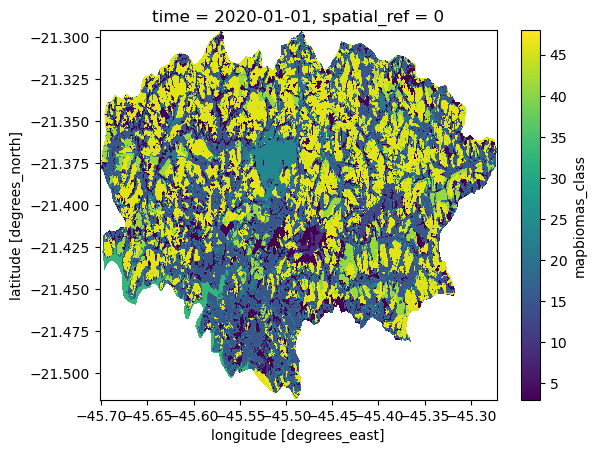

In [5]:
# um simples plot
ds.mapbiomas_class.isel(time=0).plot()

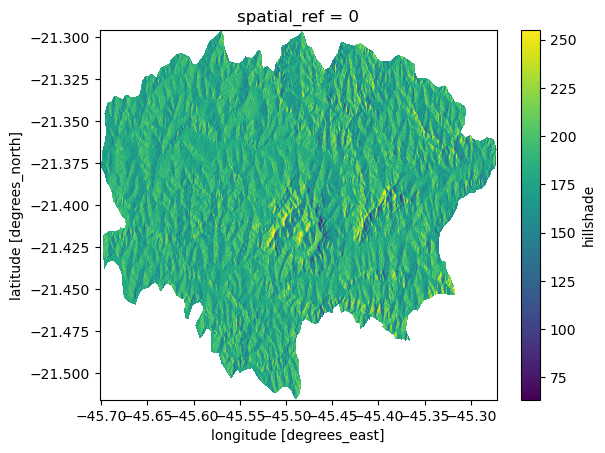

In [6]:
# outro simples plot, agora do Hillshade
ds.hillshade.plot()

In [ ]:
# 💾 Salvando o dataset como NetCDF. Descomente caso queira ver como fica o arquivo netcdf
#ds.to_netcdf("Tres_Pontas_mapbiomas_terrain.nc")
